# Setup
## Imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [3]:
import constants
import config

In [4]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Config

In [5]:
base_path = "sweeps/"

In [6]:
open_loop_color = "forestgreen"
vision_and_force_color = "darkorchid"
vision_only_color = "dodgerblue"
force_only_color = "red"

In [7]:
success_angle = 0.99*np.pi

## Functions

In [8]:
def draw_trajs(datas, idxs=None, plot_manipulator=True, progs=None, num_times=5,
              fig_height=2.1, fig_width=6, cb_shrink=0.8, max_times=None):
    if idxs is None:
        sim_args = datas["sim_args"][0]
        datas = datas["out_data"]
    else:
        sim_args = datas["sim_args"][0]
        datas = [datas["out_data"][idx] for idx in idxs]
    w_L = sim_args['sim_params'].w_L
    h_L = sim_args['sim_params'].h_L
    r = sim_args['sim_params'].r
    if max_times is None:
        max_times = np.ones(len(datas))

    # Set to be arbitrary large/small numbers
    # IMPORTANT: x and y here refer to PLOT x and ys, not sim
    min_x = 10**9
    min_y = 10**9
    max_x = -10**9
    max_y = -10**9

    # Initialize plotting vars
    fig, axs = plt.subplots(1, len(datas), figsize=(fig_width,fig_height), constrained_layout=True, sharex=True, sharey=True)
    if len(datas) == 1:
        axs = [axs]
    axs[0].set_ylabel("$z$ position")
    cmap = plt.get_cmap("viridis_r")
    
    for i, data_, in enumerate(datas):
        start_idx = data_["any_links_in_contact_idx"]
        start_time = data_["times"][start_idx]
        end_time = data_["times"][-1]
        time_range = end_time - start_time

        if progs is None:
            times_ = np.linspace(start_time, end_time, num_times)
        else:
            if type(progs[0]) is list:
                progs_ = np.array(progs[i])
            else:
                progs_ = np.array(progs)
            times_ = progs_*time_range + start_time
        ax = axs[i]

        # Draw rectangles over links
        for t in times_:
            c = cmap(((t-start_time)/time_range)/max_times[i])
            idx = np.argmax(data_["times"] >= t)

            for x, y, ang in zip(
                    data_["horizontal_paper_traces"][:,idx],
                    data_["vertical_paper_traces"][:,idx],
                    data_["angle_paper_traces"][:,idx]):

                x0 = x - np.cos(ang)*w_L/2
                y0 = y - np.sin(ang)*w_L/2

                rect = plt. Rectangle((x0, y0), w_L, h_L,
                    angle=ang*180/np.pi, color=c,)
                ax.add_patch(rect)

                # Compute bounds to be used
                min_x = min(x - w_L*1.1*0.5, min_x)
                min_y = min(y - w_L*1.1*0.5, min_y)
                max_x = max(x + w_L*1.1*0.5, max_x)
                max_y = max(y + w_L*1.1*0.5, max_y)

        # Add pedestal
        ## Get first pedestal location
        rect = plt.Rectangle(
            (data_["horizontal_paper_traces"][0,0]-w_L/2,
             data_["vertical_paper_traces"][0,0]-h_L/2),
            10,
            10,
            angle=-90,
            color=(0.2, 0.2, 0.2, 1.0)
        )
        ax.add_patch(rect)

        # Add manipulator
        if plot_manipulator:
            for t in times_:
                c = cmap(((t-start_time)/time_range)/max_times[i])
                idx = np.argmax(data_["times"] >= t)

                x = data_["horizontal_manipulator_trace"][idx]
                y = data_["vertical_manipulator_trace"][idx]

                min_x = min(x - r*1.1, min_x)
                min_y = min(y - r*1.1, min_y)
                max_x = max(x + r*1.1, max_x)
                max_y = max(y + r*1.1, max_y)

                circ = plt.Circle((x, y), r*1.1, color=c, alpha=0.3, snap=False)
                ax.add_patch(circ)

        ax.set_xlabel("$x$ position")
        ax.set_aspect("equal")

    # Set lims (can do at the end because sharex and sharey are true)
    min_plot_x = min_x - (max_x-min_x)*0.1
    max_plot_x = max_x + (max_x-min_x)*0.1
    min_x_tick = np.floor(min_plot_x*10)/10
    max_x_tick = np.ceil(max_plot_x*10)/10
    xticks = np.arange(min_x_tick, max_x_tick+1e-5, 0.1)
    ax.set_xticks(xticks)

    min_plot_y = min_y - (max_y-min_y)*0.1
    max_plot_y = max_y + (max_y-min_y)*0.1
    min_y_tick = np.floor(min_plot_y*10)/10
    max_y_tick = np.ceil(max_plot_y*10)/10
    yticks = np.arange(min_y_tick, max_y_tick+1e-5, 0.1)
    ax.set_yticks(yticks)
    ax.set_ylim(min_plot_y, max_plot_y)
    plt.xlim(min_plot_x, max_plot_x)
    cb = fig.colorbar(cm.ScalarMappable(cmap="viridis_r"), shrink=cb_shrink)
    cb.set_label("Normalized time")

    return fig, axs, cb

In [9]:
def get_overall_thetas(data, idx):
    p_W_LL = np.array([
            data["out_data"][idx]["horizontal_paper_traces"][-1,:],
            data["out_data"][idx]["vertical_paper_traces"][-1,:]
        ])
    p_W_FJ = np.array([
        data["out_data"][idx]["horizontal_paper_traces"][0,:] - data["sim_args"][idx]["sim_params"].w_L/2,
        data["out_data"][idx]["vertical_paper_traces"][0,:] + data["sim_args"][idx]["sim_params"].h_L*1.5
    ])
    p_FJ_LL = p_W_LL - p_W_FJ
    atan_x = -p_FJ_LL[0].flatten()
    atan_y = p_FJ_LL[1].flatten()
    overall_theta = np.arctan2(atan_y,atan_x)
    for i in range(1, len(overall_theta)):
        if overall_theta[i] - overall_theta[i-1] > 0.99*2*np.pi:
            overall_theta[i] -= 2*np.pi
        if overall_theta[i] - overall_theta[i-1] < -0.99*2*np.pi:
            overall_theta[i] += 2*np.pi
    return overall_theta

# Intro sweeps

In [10]:
data = np.load(base_path + "traces.npz", allow_pickle=True)

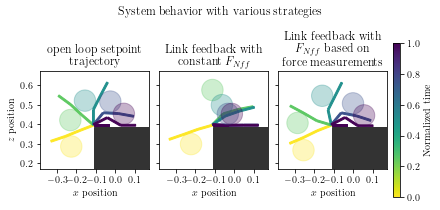

In [11]:
plot_manipulator=True
data = np.load(base_path + "traces.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

fig, axs, cb = draw_trajs(data, plot_manipulator=plot_manipulator,
               fig_height=3)
titles = ["open loop setpoint\ntrajectory",
          r"Link feedback with" + "\n" +
          "constant $F_{Nff}$",
          "Link feedback with" + "\n" +
          "$F_{Nff}$ based on" + "\n" +
          "force measurements"]
for title, ax in zip(titles, axs):
    ax.set_title(title)
plt.suptitle("System behavior with various strategies")
fig.savefig("traj_drawings.pgf", backend="pgf")
plt.show()

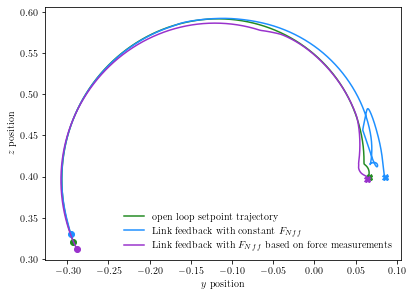

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
colors = [open_loop_color, vision_only_color, vision_and_force_color]
titles = ["open loop setpoint trajectory",
          r"Link feedback with constant $F_{Nff}$",
          "Link feedback with $F_{Nff}$ based on force measurements"]
for i, (data_, color, title) in enumerate(zip(data['out_data'], colors, titles)):
    start_idx = data_["any_links_in_contact_idx"]
    plt.plot(data_["horizontal_paper_traces"][-1,start_idx:],
             data_["vertical_paper_traces"][-1,start_idx:], color=color, label=title)
    plt.plot(data_["horizontal_paper_traces"][-1,start_idx],
             data_["vertical_paper_traces"][-1,start_idx],
             marker='o', color=color)
    plt.plot(data_["horizontal_paper_traces"][-1,-1],
             data_["vertical_paper_traces"][-1,-1], marker='X', color=color)
plt.legend(frameon=False)
plt.xlabel("$y$ position")
plt.ylabel("$z$ position")
plt.gca().set_aspect("equal")

fig.savefig("traj_plots.pgf", backend="pgf")
plt.show()

# Task parameters

## Stiffness

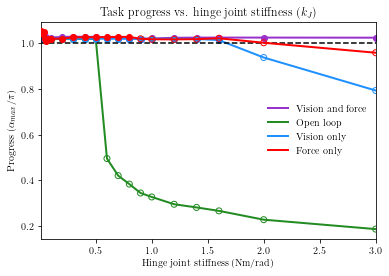

In [13]:
datas = [
    np.load(base_path + "vision_and_force__k_J.npz", allow_pickle=True),
    np.load(base_path + "open_loop__k_J.npz", allow_pickle=True),
    np.load(base_path + "vision_only__k_J.npz", allow_pickle=True),
    np.load(base_path + "force_only__k_J.npz", allow_pickle=True),
]
labels = ["Vision and force", "Open loop","Vision only", "Force only"]
colors = [vision_and_force_color, open_loop_color, vision_only_color, force_only_color]

for i, (data, label, color) in enumerate(zip(datas, labels, colors)):
    x_axis = data["sweep_vars"][:,0]
    y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])/success_angle
    succ_idxs = data["successes"].flatten()
    fail_idxs = np.logical_not(succ_idxs)
    plt.plot(x_axis, y_axis, linestyle='-', linewidth=2, label=label, zorder=i, color=color)
    plt.scatter(x_axis[succ_idxs], y_axis[succ_idxs], color=color, zorder=i)
    plt.scatter(x_axis[fail_idxs], y_axis[fail_idxs], facecolors='none', color=color, zorder=i)
plt.legend(frameon=False)
plt.xlabel("Hinge joint stiffness (Nm/rad)")
plt.ylabel(r"Progress ($\alpha_{max}/\pi$)")
plt.autoscale(enable=True, axis='x', tight=True)
plt.axhline(1, color='k', linestyle='--')
plt.title("Task progress vs. hinge joint stiffness ($k_J$)")
plt.gcf().savefig("k_J_sweep.pgf", backend="pgf")
plt.show()

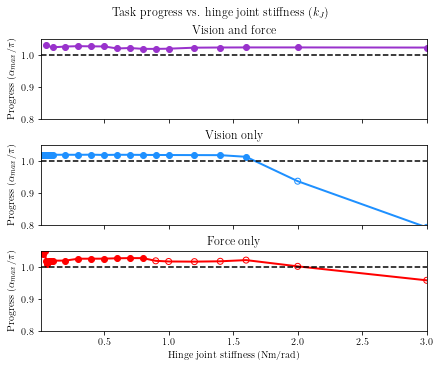

In [14]:
datas = [
    np.load(base_path + "vision_and_force__k_J.npz", allow_pickle=True),
    # np.load(base_path + "open_loop__k_J.npz", allow_pickle=True),
    np.load(base_path + "vision_only__k_J.npz", allow_pickle=True),
    np.load(base_path + "force_only__k_J.npz", allow_pickle=True),
]
labels = [
    "Vision and force",
    # "Open loop",
    "Vision only",
    "Force only"
]
colors = [
    vision_and_force_color,
    # open_loop_color,
    vision_only_color,
    force_only_color
]
fig, axs = plt.subplots(len(datas), 1, figsize=(6,5), constrained_layout=True,sharex=True,sharey=True)
if len(datas) == 1:
    axs = [axs]

for i, (data, label, color, ax) in enumerate(zip(datas, labels, colors, axs)):
    x_axis = data["sweep_vars"][:,0]
    y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])/success_angle
    succ_idxs = data["successes"].flatten()
    fail_idxs = np.logical_not(succ_idxs)
    ax.plot(x_axis, y_axis, linestyle='-', linewidth=2, label=label, zorder=i, color=color)
    ax.scatter(x_axis[succ_idxs], y_axis[succ_idxs], color=color, zorder=i)
    ax.scatter(x_axis[fail_idxs], y_axis[fail_idxs], facecolors='none', color=color, zorder=i)
    ax.axhline(1, color='k', linestyle='--')
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_title(label)
    ax.set_ylabel(r"Progress ($\alpha_{max}/\pi$)")
ax.set_xlabel("Hinge joint stiffness (Nm/rad)")
plt.ylim(0.8,1.05)
plt.suptitle("Task progress vs. hinge joint stiffness ($k_J$)")
plt.gcf().savefig("k_J_sweep_zoom.pgf", backend="pgf")
plt.show()

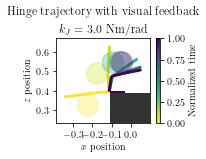

In [15]:
plot_manipulator=True
data = np.load(base_path + "vision_only__k_J.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

fig, axs, cb = draw_trajs(data, idxs=[-1], plot_manipulator=plot_manipulator,
                          progs=[0, 0.05, 0.25, 0.45, 0.7],
                          max_times=[0.7], fig_width=2.7, cb_shrink=1)
axs[0].set_title("$k_J = {}$ Nm/rad".format(data["sweep_vars"][-1,0]))
plt.suptitle("Hinge trajectory with visual feedback")
fig.savefig("k_J_vis_full_hinge.pgf", backend="pgf")
plt.show()

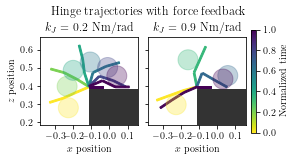

In [16]:
plot_manipulator=True
data = np.load(base_path + "force_only__k_J.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

idxs = [10, 17]
fig, axs, cb = draw_trajs(data, idxs=idxs, plot_manipulator=plot_manipulator, max_times=[1, 0.6],
                          progs=[[0,0.2,0.4,0.6,0.8,1], [0, 0.2, 0.4, 0.6]],
                          fig_width=4, cb_shrink=1)
titles = ["$k_J = {}$ Nm/rad".format(data["sweep_vars"][i,0]) for i in idxs]
for title, ax in zip(titles, axs):
    ax.set_title(title)
plt.suptitle(r"Hinge trajectories with force feedback")
fig.savefig("k_J_force_full_hinge.pgf", backend="pgf")
plt.show()

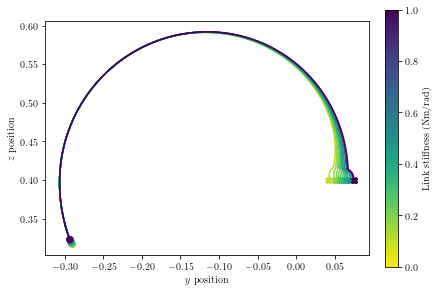

In [20]:
data = np.load(base_path + "open_loop__mu.npz", allow_pickle=True)
fig, axs = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)

color_map = cm.ScalarMappable(cmap="viridis_r", norm=plt.Normalize(0,np.max(data['sweep_vars'])))
for i, (data_, k_J) in enumerate(zip(data['out_data'][3:], data['sweep_vars'][3:,0])):
    c = color_map.to_rgba(k_J)
    start_idx = data_["any_links_in_contact_idx"]
    p = plt.plot(data_["horizontal_paper_traces"][-1,start_idx:],
             data_["vertical_paper_traces"][-1,start_idx:], color=c)
    plt.plot(data_["horizontal_paper_traces"][-1,start_idx],
             data_["vertical_paper_traces"][-1,start_idx],
             marker='o', color=c)
    plt.plot(data_["horizontal_paper_traces"][-1,-1],
             data_["vertical_paper_traces"][-1,-1], marker='X', color=c)
plt.xlabel("$y$ position")
plt.ylabel("$z$ position")

cb = fig.colorbar(color_map)
plt.gca().set_aspect("equal")
cb.set_label("Link stiffness (Nm/rad)")
plt.gcf().savefig("k_J_plot.pgf", backend="pgf")
plt.show()

## Link mass

### Sweep

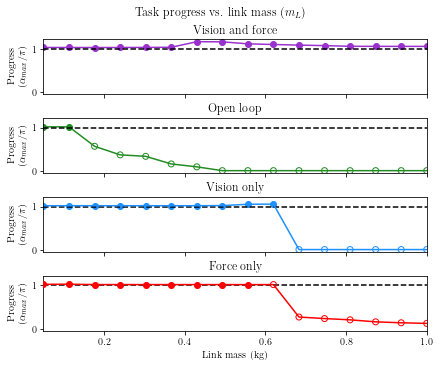

In [275]:
datas = [
    np.load(base_path + "vision_and_force__m_L.npz", allow_pickle=True),
    np.load(base_path + "open_loop__m_L.npz", allow_pickle=True),
    np.load(base_path + "vision_only__m_L.npz", allow_pickle=True),
    np.load(base_path + "force_only__m_L.npz", allow_pickle=True),
]
labels = [
    "Vision and force",
    "Open loop",
    "Vision only",
    "Force only"
]
colors = [
    vision_and_force_color,
    open_loop_color,
    vision_only_color,
    force_only_color
]
fig, axs = plt.subplots(len(datas), 1, figsize=(6,5), constrained_layout=True,sharex=True,sharey=True)
# fig, axs = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True,sharex=True,sharey=True)
if type(axs) != np.ndarray:
    axs = [axs, axs, axs, axs]

for i, (data, label, color, ax) in enumerate(zip(datas, labels, colors, axs)):
    ax.axhline(1, color='k', linestyle='--')
    x_axis = data["sweep_vars"]
    y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])/success_angle
    succ_idxs = data["successes"].flatten()
    fail_idxs = np.logical_not(succ_idxs)
    ax.plot(x_axis, y_axis, '-', label=label, zorder=i, color=color)
    ax.scatter(x_axis[succ_idxs], y_axis[succ_idxs], color=color, zorder=i)
    ax.scatter(x_axis[fail_idxs], y_axis[fail_idxs], facecolors='none', color=color, zorder=i)
    ax.set_ylabel("Progress\n" + r"($\alpha_{max}/\pi$)")
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_title(label)
# plt.legend(frameon=False)
plt.xlabel("Link mass (kg)")
plt.suptitle("Task progress vs. link mass ($m_L$)")

plt.gcf().savefig("m_L_sweep.pgf", backend="pgf")
plt.show()

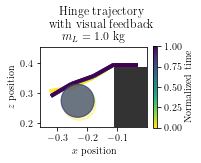

In [134]:
plot_manipulator=True
data = np.load(base_path + "vision_only__m_L.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

fig, axs, cb = draw_trajs(data, idxs=[-1], plot_manipulator=plot_manipulator,
                          fig_width=2.7, cb_shrink=1)
axs[0].set_title("$m_L = {}$ kg".format(data["sweep_vars"][-1,0]))
plt.suptitle("Hinge trajectory\nwith visual feedback")
fig.savefig("m_L_vis_full_hinge.pgf", backend="pgf")
plt.show()

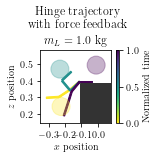

In [137]:
plot_manipulator=True
data = np.load(base_path + "force_only__m_L.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

fig, axs, cb = draw_trajs(data, idxs=[-1], plot_manipulator=plot_manipulator,
                          fig_width=2.3, cb_shrink=1, progs=[0, 0.15, 0.3], max_times=[0.3])
axs[0].set_title("$m_L = {}$ kg".format(data["sweep_vars"][-1,0]))
plt.suptitle("Hinge trajectory\nwith force feedback")
fig.savefig("m_L_force_full_hinge.pgf", backend="pgf")
plt.show()

## Coefficient of friction

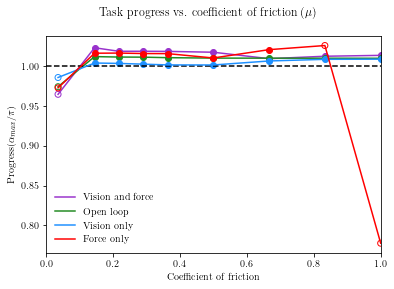

In [276]:
datas = [
    np.load(base_path + "vision_and_force__mu.npz", allow_pickle=True),
    np.load(base_path + "open_loop__mu.npz", allow_pickle=True),
    np.load(base_path + "vision_only__mu.npz", allow_pickle=True),
    np.load(base_path + "force_only__mu.npz", allow_pickle=True),
]
labels = [
    "Vision and force",
    "Open loop",
    "Vision only",
    "Force only"
]
colors = [
    vision_and_force_color,
    open_loop_color,
    vision_only_color,
    force_only_color
]
plt.axhline(1, color='k', linestyle='--')
idxs = np.ones(16, dtype=bool)
idxs[0] = False
idxs[2] = False
idxs[3] = False
idxs[5] = False
idxs[7] = False
idxs[9] = False
idxs[11] = False
for i, (data, label, color) in enumerate(zip(datas, labels, colors)):
    x_axis = data["sweep_vars"]
    y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])/np.pi
    succ_idxs = data["successes"].flatten()
    fail_idxs = np.logical_not(succ_idxs)
    p = plt.plot(x_axis[idxs], y_axis[idxs], '-', label=label, zorder=i, color=color)
    plt.scatter(x_axis[np.logical_and(succ_idxs,idxs)],
                y_axis[np.logical_and(succ_idxs,idxs)], color=p[0].get_color(), zorder=i)
    plt.scatter(x_axis[np.logical_and(fail_idxs,idxs)],
                y_axis[np.logical_and(fail_idxs,idxs)], facecolors='none', color=p[0].get_color(), zorder=i)
plt.legend(frameon=False)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Coefficient of friction")
plt.ylabel("Progress" + r"($\alpha_{max}/\pi$)")
# ylim = plt.ylim()
plt.xlim(0,1)
plt.suptitle("Task progress vs. coefficient of friction ($\mu$)")
# plt.ylim(0,1.05)
plt.gcf().savefig("mu_sweep.pgf", backend="pgf")
plt.show()

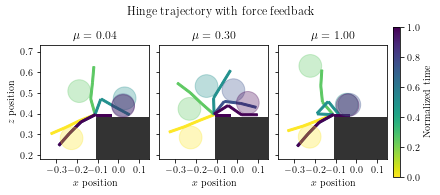

In [277]:
plot_manipulator=True
data = np.load(base_path + "force_only__mu.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

idxs = [1, 8, -1]
fig, axs, cb = draw_trajs(data, idxs=idxs, plot_manipulator=plot_manipulator,
                          fig_height=2.6, cb_shrink=1)#, progs=[0, 0.15, 0.3], max_times=[0.3])
for ax, i in zip(axs, idxs):
    ax.set_title(r"$\mu = {:.2f}$".format(data["sweep_vars"][i,0]+0.005)) # fixing floating point rounding annoyance
plt.suptitle("Hinge trajectory with force feedback")
fig.savefig("mu_force_full_hinge.pgf", backend="pgf")
plt.show()

Currently cherry picking points because I think the variation at low coefficients of friction actually has to do with the different strategies making contact at different points.

# Control parameters

## Feedforward $F_N$

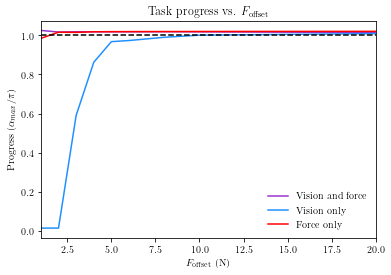

In [283]:
datas = [
    np.load(base_path + "vision_and_force__ff_FN.npz", allow_pickle=True),
    np.load(base_path + "vision_only__ff_FN.npz", allow_pickle=True),
    np.load(base_path + "force_only__ff_FN.npz", allow_pickle=True),
]
labels = [
    "Vision and force",
    "Vision only",
    "Force only"
]
colors = [
    vision_and_force_color,
    vision_only_color,
    force_only_color
]

for i, (data, label, color) in enumerate(zip(datas, labels, colors)):
    x_axis = data["sweep_vars"][1:]
    y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])[1:]/np.pi
    succ_idxs = data["successes"].flatten()[1:]
    fail_idxs = np.logical_not(succ_idxs)
    plt.plot(x_axis, y_axis, '-', label=label, zorder=i, color=color)
    # plt.scatter(x_axis[succ_idxs], y_axis[succ_idxs], color=color, zorder=i)
    # plt.scatter(x_axis[fail_idxs], y_axis[fail_idxs], facecolors='none', color=color, zorder=i)
plt.legend(frameon=False)
plt.xlabel(r"$F_\mathrm{offset}$ (N)")
plt.ylabel(r"Progress ($\alpha_{max}/\pi$)")
plt.title("Task progress vs. $F_\mathrm{offset}$")
# plt.title(r"Controller performance as a function of $F_\mathrm{offset}$")
plt.autoscale(enable=True, axis='x', tight=True)
xlims = plt.xlim()
plt.xlim(xlims[0],20)
plt.axhline(1, color='k', linestyle='--')
plt.gcf().savefig("F_offset_sweep.pgf", backend="pgf")
plt.show()

## Impedance

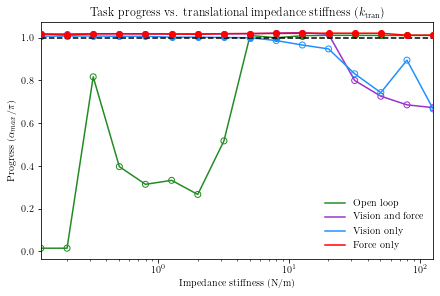

In [285]:
datas = [
    np.load(base_path + "open_loop__impedance.npz", allow_pickle=True),
    np.load(base_path + "vision_and_force__impedance.npz", allow_pickle=True),
    np.load(base_path + "vision_only__impedance.npz", allow_pickle=True),
    np.load(base_path + "force_only__impedance.npz", allow_pickle=True),
]
labels = [
    "Open loop",
    "Vision and force",
    "Vision only",
    "Force only"
]
colors = [
    open_loop_color,
    vision_and_force_color,
    vision_only_color,
    force_only_color
]
# fig, axs = plt.subplots(len(datas), 1, figsize=(6,4), constrained_layout=True, sharex=True, sharey=True)
fig, axs = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True, sharex=True, sharey=True)

if type(axs) != np.ndarray:
    axs = [axs, axs, axs, axs]

for i, (data, label, color, ax) in enumerate(zip(datas, labels, colors, axs)):
    x_axis = data["sweep_vars"]
    y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])/np.pi
    succ_idxs = data["successes"].flatten()
    fail_idxs = np.logical_not(succ_idxs)
    p = ax.semilogx(4*x_axis, y_axis, '-', label=label, zorder=i, color=color)
    ax.scatter(4*x_axis[succ_idxs], y_axis[succ_idxs], color=p[0].get_color(), zorder=i)
    ax.scatter(4*x_axis[fail_idxs], y_axis[fail_idxs], facecolors='none', color=p[0].get_color(), zorder=i)
plt.axhline(1, color='k', linestyle='--')
plt.legend(frameon=False)
plt.xlabel("Impedance stiffness (N/m)")
plt.ylabel(r"Progress ($\alpha_{max}/\pi$)")
ax.autoscale(enable=True, axis='x', tight=True)
plt.title(r"Task progress vs. translational impedance stiffness ($k_\mathrm{tran}$)")
fig.savefig("impedance_sweep.pgf", backend="pgf")
plt.show()

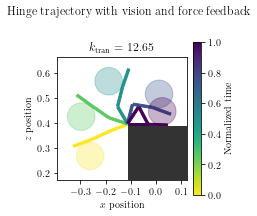

In [288]:
plot_manipulator=True
data = np.load(base_path + "vision_and_force__impedance.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

idxs = [-6]
fig, axs, cb = draw_trajs(data, idxs=idxs, plot_manipulator=plot_manipulator, num_times=5,
                          fig_height=3, fig_width=3)#, progs=[0, 0.15, 0.3], max_times=[0.3])
for ax, i in zip(axs, idxs):
    ax.set_title(r"$k_\mathrm{tran} = " + "{:.2f}$".format(4*data["sweep_vars"][i,0]))
plt.suptitle("Hinge trajectory with vision and force feedback")
fig.savefig("impedance_vision_and_force_full_hinge_1.pgf", backend="pgf")
plt.show()

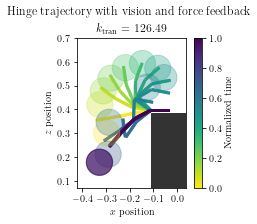

In [289]:
plot_manipulator=True
data = np.load(base_path + "vision_and_force__impedance.npz", allow_pickle=True)
sim_args = data["sim_args"][0]

idxs = [-1]
fig, axs, cb = draw_trajs(data, idxs=idxs, plot_manipulator=plot_manipulator, num_times=15,
                          fig_height=3, fig_width=3, cb_shrink=1)#, progs=[0, 0.15, 0.3], max_times=[0.3])
for ax, i in zip(axs, idxs):
    ax.set_title(r"$k_\mathrm{tran} = " + "{:.2f}$".format(4*data["sweep_vars"][i,0]))
plt.suptitle("Hinge trajectory with vision and force feedback")
fig.savefig("impedance_vision_and_force_full_hinge_2.pgf", backend="pgf")
plt.show()

# Noise
## $F_n$

In [23]:
data = np.load(base_path + "vision_and_force__Fn_noise.npz", allow_pickle=True)

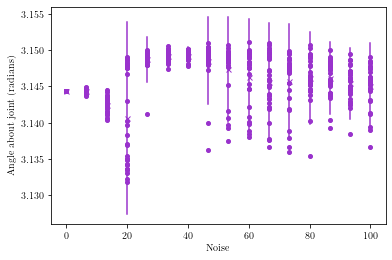

In [24]:
num_samples = data["num_samples"]
num_noises = int(data["sweep_vars"].shape[0]/num_samples)
noises = data["sweep_vars"][::num_samples,0]
raw_y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])
raw_succ_idxs = data["successes"].flatten()
raw_fail_idxs = np.logical_not(raw_succ_idxs)
portion_success = []

for i, noise in enumerate(noises):
    data_for_noise = raw_y_axis[i*num_samples:(i+1)*num_samples]
    mean = np.mean(data_for_noise)
    stddev = np.std(data_for_noise, ddof=1)
    plt.plot(np.ones(num_samples)*noise, data_for_noise, ' o', markersize=4, color=vision_and_force_color)
    plt.plot(noise, mean, ' x', markersize=5, color=vision_and_force_color)
    plt.plot([noise, noise], [mean-2*stddev,mean+2*stddev], '-', color=vision_and_force_color)
    
    succ_idxs = raw_succ_idxs[i*num_samples:(i+1)*num_samples]
    fail_idxs = raw_fail_idxs[i*num_samples:(i+1)*num_samples]
    portion_success.append(np.count_nonzero(succ_idxs)/num_samples)
plt.xlabel("Noise")
plt.ylabel("Angle about joint (radians)")
plt.show()

In [25]:
portion_success       

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

0.0
6.666666666666667
13.333333333333334
20.0
26.666666666666668
33.333333333333336
40.0
46.66666666666667
53.333333333333336
60.0
66.66666666666667
73.33333333333334
80.0
86.66666666666667
93.33333333333334
100.0


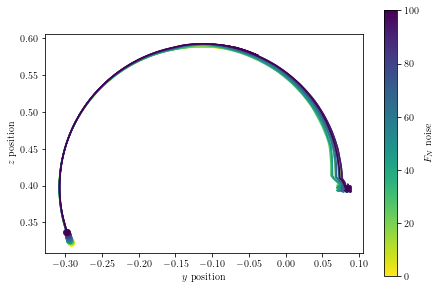

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)

color_map = cm.ScalarMappable(cmap="viridis_r", norm=plt.Normalize(0,np.max(data['sweep_vars'])))
for i, (data_, Fn_noise) in enumerate(zip(
    data['out_data'][::data["num_samples"]], data['sweep_vars'].flatten()[::data["num_samples"]])):
    print(Fn_noise)
    c = color_map.to_rgba(Fn_noise)
    start_idx = data_["any_links_in_contact_idx"]
    p = plt.plot(data_["horizontal_paper_traces"][-1,start_idx:],
             data_["vertical_paper_traces"][-1,start_idx:], color=c)
    plt.plot(data_["horizontal_paper_traces"][-1,start_idx],
             data_["vertical_paper_traces"][-1,start_idx],
             marker='o', color=c)
    plt.plot(data_["horizontal_paper_traces"][-1,-1],
             data_["vertical_paper_traces"][-1,-1], marker='X', color=c)
plt.xlabel("$y$ position")
plt.ylabel("$z$ position")

cb = fig.colorbar(color_map)
plt.gca().set_aspect("equal")
cb.set_label("$F_N$ noise")
plt.gcf().savefig("Fn_noise_plot.pgf", backend="pgf")
plt.show()

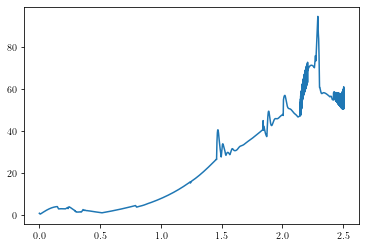

In [27]:
plt.figure()
plt.plot(data["out_data"][0]["times"], data["out_data"][0]["max_F_ONs"])
plt.show()

## Link noise

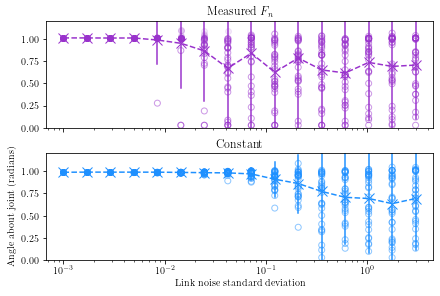

In [21]:
datas = [
    np.load(base_path + "vision_and_force__link_noise.npz", allow_pickle=True),
    np.load(base_path + "vision_only__link_noise.npz", allow_pickle=True),
]
labels = ["Measured $F_n$", "Constant"]
colors = [vision_and_force_color, vision_only_color]
fig, axs = plt.subplots(len(datas), 1, figsize=(6,4), constrained_layout=True, sharex=True, sharey=True)
if len(datas) == 1:
    axs = [axs]
portion_successes = []

for data, label, color, ax in zip(datas, labels, colors, axs):
    num_samples = data["num_samples"]
    num_noises = int(data["sweep_vars"].shape[0]/num_samples)
    noises = data["sweep_vars"][::num_samples,0]
    raw_y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])
    raw_succ_idxs = data["successes"].flatten()
    raw_fail_idxs = np.logical_not(raw_succ_idxs)
    means = []
    portion_success = []
    
    for i, noise in enumerate(noises):
        # print(noise)
        data_for_noise = raw_y_axis[i*num_samples:(i+1)*num_samples]
        mean = np.mean(data_for_noise)
        means.append(mean)
        stddev = np.std(data_for_noise, ddof=1)
        ax.semilogx(
            [noise, noise], np.array([mean-2*stddev,mean+2*stddev])/success_angle, '-', color=color)
        
        x_axis = np.ones(num_samples)*noise
        y_axis = data_for_noise
        succ_idxs = raw_succ_idxs[i*num_samples:(i+1)*num_samples]
        fail_idxs = raw_fail_idxs[i*num_samples:(i+1)*num_samples]
        # print(succ_idxs)
        # print(np.count_nonzero(succ_idxs))
        
        portion_success.append(np.count_nonzero(succ_idxs)/num_samples)
        
        ax.scatter(x_axis[succ_idxs], y_axis[succ_idxs]/success_angle, color=color, zorder=i, alpha=0.1)
        ax.scatter(x_axis[fail_idxs], y_axis[fail_idxs]/success_angle, facecolors='none',
                   color=color, zorder=i, alpha=0.5)
    portion_successes.append(portion_success)
        
    ax.set_title(label)
    ax.semilogx(noises, np.array(means)/success_angle, '--x', markersize=10, color=color)
ax.set_xlabel("Link noise standard deviation")
ax.set_ylabel("Angle about joint (radians)")
plt.ylim(0,1.2)
plt.show()

In [ ]:
portion_successes

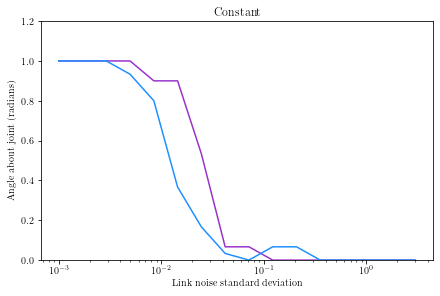

In [22]:
datas = [
    np.load(base_path + "vision_and_force__link_noise.npz", allow_pickle=True),
    np.load(base_path + "vision_only__link_noise.npz", allow_pickle=True),
]
labels = ["Measured $F_n$", "Constant"]
colors = [vision_and_force_color, vision_only_color]
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True, sharex=True, sharey=True)
portion_successes = []

for data, label, color in zip(datas, labels, colors):
    num_samples = data["num_samples"]
    num_noises = int(data["sweep_vars"].shape[0]/num_samples)
    noises = data["sweep_vars"][::num_samples,0]
    # raw_y_axis = np.array([val["max_overall_theta"] for val in data["out_data"]])
    raw_succ_idxs = data["successes"].flatten()
    raw_fail_idxs = np.logical_not(raw_succ_idxs)
    means = []
    portion_success = []
    
    for i in range(len(noises)):
        succ_idxs = raw_succ_idxs[i*num_samples:(i+1)*num_samples]
        fail_idxs = raw_fail_idxs[i*num_samples:(i+1)*num_samples]
        
        portion_success.append(np.count_nonzero(succ_idxs)/num_samples)
    portion_successes.append(portion_success)
    ax.semilogx(noises, portion_success, color=color, zorder=i)
        
    ax.set_title(label)
ax.set_xlabel("Link noise standard deviation")
ax.set_ylabel("Angle about joint (radians)")
plt.ylim(0,1.2)
plt.show()